In [1]:

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import numpy as np
import json
from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
from sklearn.metrics import classification_report, recall_score,precision_score , f1_score, accuracy_score
import sys
sys.path.append("HateRecognition/target_model/")
from utils import preprocessing, load_anno_data, data_loader, define_target, create_model
from bertopic import BERTopic
from TopicTuner.topictuner import TopicModelTuner as TMT
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from sklearn.model_selection import StratifiedKFold
from hdbscan import HDBSCAN
from sklearn.metrics import confusion_matrix


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
sys.path.append("./HateRecognition/data/")
df = pd.read_csv(r'./HateRecognition/data/parler_annotated_data.csv')
df

,id,text,label_mean,disputable_post
0,a113a2d777ca4211ae97a193eee44dc1,Black men are taught that a word justifies all...,3.60,True
1,bb348c5f20a84be1bc3467d32312341c,Biden and his supporters are claiming that Bid...,4.00,True
2,39df38e04a44423f93ba1d1dc79070c9,Pelosi; âOne way or another Joe Biden will b...,1.25,False
3,68dd325894274be79f73767e92e64702,Northern California Declares Independence From...,3.00,True
4,9503e349140b4bbe9e496f4c0f15f830,Whistleblower claims top DHS officials sought ...,1.50,False
...,...,...,...,...
10116,bd2e05ec9a7942b78fbedab3d75d1079,Minneapolis City Council Votes To Eliminate Po...,1.00,False
10117,23ce3d9f0f09448abe4665b93dab2aef,And just like that facebook is gone,1.00,False
10118,163f0fad195c4cb58ef31920921a1ab9,Obama Says He Will Campaign For Biden If He Ca...,1.00,False
10119,ca70cdcc29084720990fc21ca6a3e31d,Shoup Voting Machine,1.00,False


In [4]:
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)
# text = 'This is an english text.'
# doc = nlp(text)
# print(doc._.language)

In [5]:
df['lang'] = df.text.apply(lambda x: nlp(x)._.language['language'])
df['lang']

0        en
1        en
2        en
3        en
4        en
         ..
10116    en
10117    en
10118    en
10119    en
10120    en
Name: lang, Length: 10121, dtype: object

In [6]:
df = df[df['lang']=='en']

In [7]:
hate_df = pd.read_csv(r'./HateRecognition/data/filtered_hatexplain_data.csv')

In [8]:
topic_model = BERTopic.load('./HateRecognition/target_model/topic_model')
# topics, probs = topic_model.fit_transform(hate_df.text)

Tue Jan 24 16:35:45 2023 Building and compiling search function


In [9]:
topics, probs = topic_model.transform(df.text.values.tolist())

Epochs completed:   0%|            0/30 [00:00]

In [10]:
df['topics'] = [topic_model.topic_names[x] for x in topics]
df['topics'] 

0        0_nigger_white_niggers_number
1         2_moslem_muslim_number_islam
2           -1_coons_anglin_coon_giant
3        3_faggots_faggot_queers_dykes
4        0_nigger_white_niggers_number
                     ...              
10116    0_nigger_white_niggers_number
10117     2_moslem_muslim_number_islam
10118     2_moslem_muslim_number_islam
10119    0_nigger_white_niggers_number
10120            1_kike_jews_jew_white
Name: topics, Length: 10029, dtype: object

<AxesSubplot:>

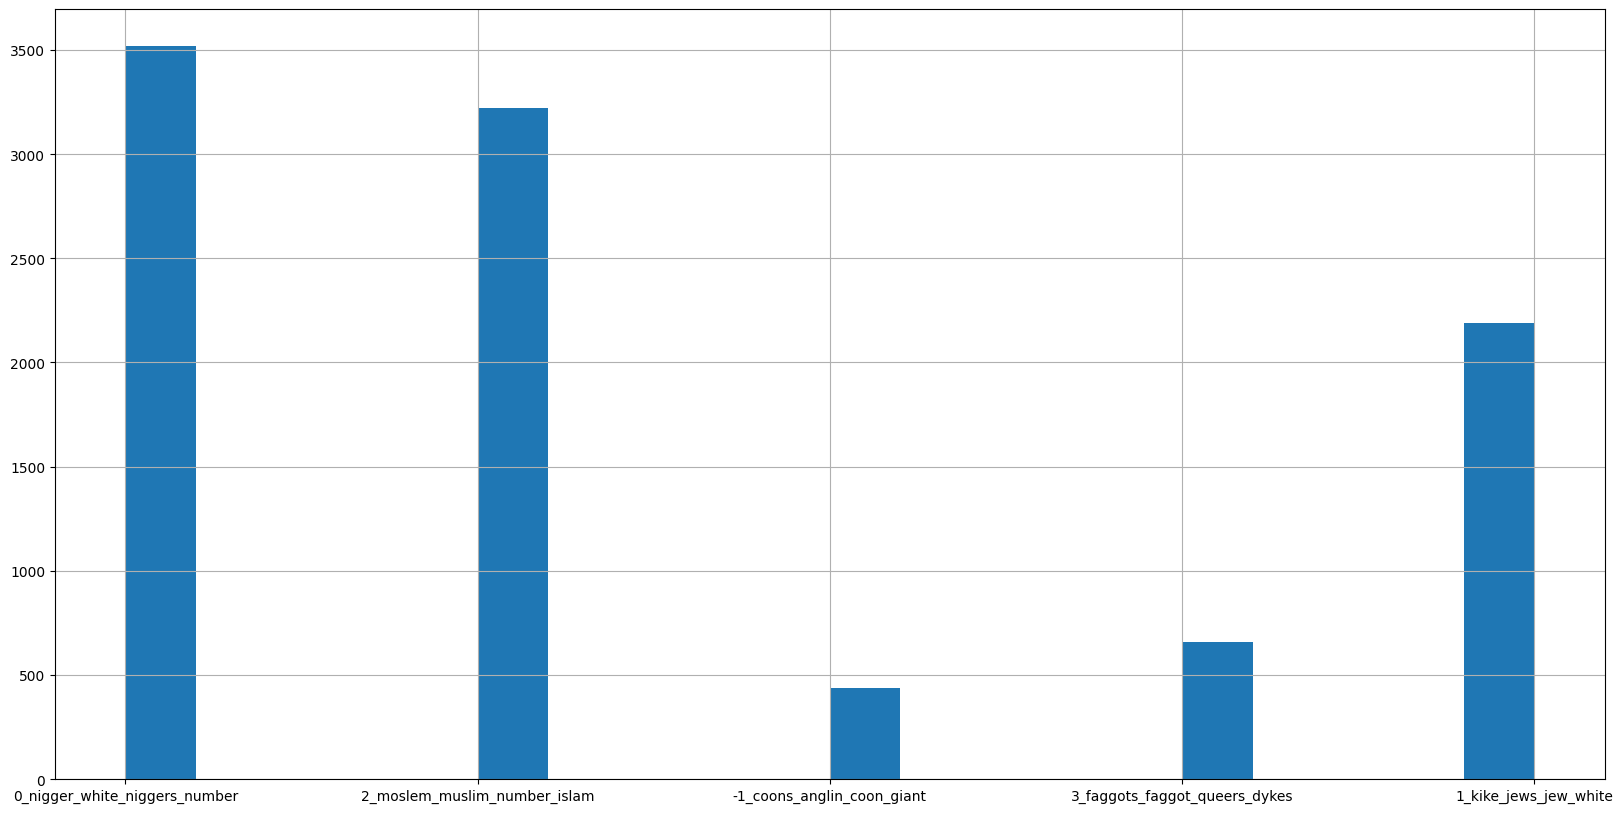

In [11]:
df['topics'].hist(figsize=(20,10),bins=20)

In [12]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False,
    hidden_act ='relu',
    classifier_dropout =0.3
    
)
model.load_state_dict(state_dict=torch.load('fine_tuned_with_topic'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [13]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True,
    truncation=True
    )

In [14]:
token_id = []
attention_masks = []
text = df.text.values.tolist()
with_topic=True
MAX_LEN = max([len(x.split()) for x in text])
print(MAX_LEN)
for i, sample in enumerate(text):
  topic_name = None
  if with_topic:
    topic_id = topics[i]
    topic_name = topic_model.topic_names[topic_id]
    topic_name = ' '.join(topic_name.split('_')[1:])
  encoding_dict = preprocessing(sample,tokenizer, MAX_LEN, topic_name)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)

195


In [15]:

batch_size = 16


In [19]:
train_set = TensorDataset(token_id, 
                              attention_masks)

data = DataLoader(
                train_set,
                sampler = SequentialSampler(train_set),
                batch_size = batch_size
            )

In [20]:
import gc
torch.cuda.empty_cache()
gc.collect()
model.to('cuda')
pred_labels = []
for batch in data:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask = batch
        eval_output = model(b_input_ids, 
                            token_type_ids = None, 
                            attention_mask = b_input_mask)
        preds = torch.argmax(eval_output.logits, dim=1)
        pred_labels.extend(preds.cpu().numpy())

In [25]:
labl_dict = {0:'African', 1:'Homosexual', 2:'Islam', 3:'Jewish'}

In [26]:
df['pred'] = [labl_dict[x] for x in pred_labels]
df['pred'] 

0           African
1             Islam
2           African
3        Homosexual
4           African
            ...    
10116       African
10117         Islam
10118        Jewish
10119       African
10120        Jewish
Name: pred, Length: 10029, dtype: object

<AxesSubplot:>

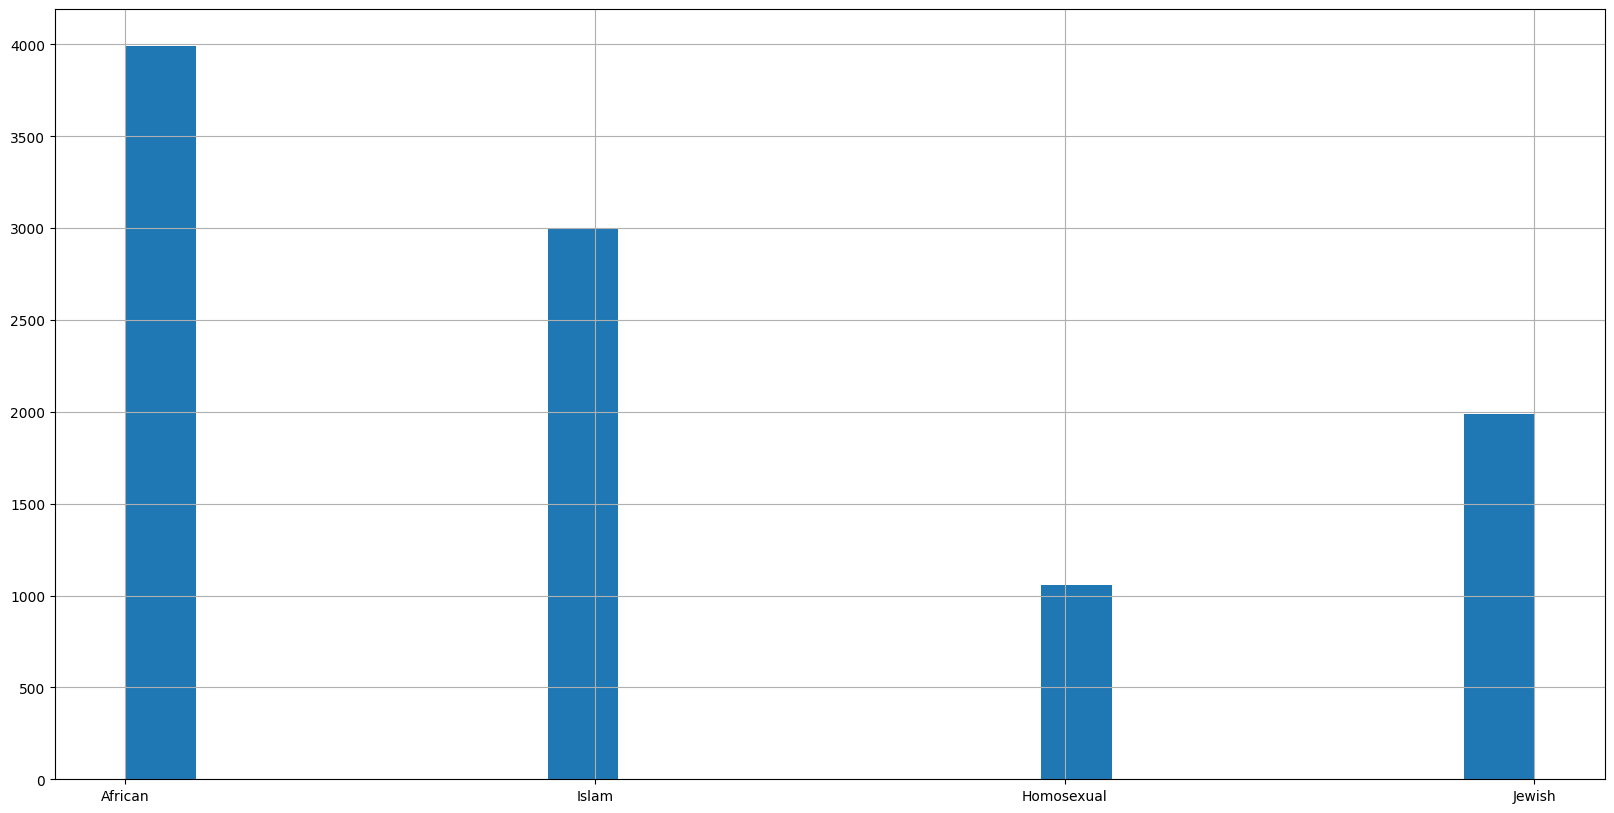

In [28]:
df['pred'].hist(figsize=(20,10),bins=20)

In [50]:
g_hate_df = df.groupby(['topics', 'pred']).count()['text'].reset_index()
p_g_hate_df = g_hate_df.pivot_table(columns=g_hate_df.topics, index=g_hate_df.pred)
p_g_hate_df.columns = p_g_hate_df.columns.droplevel(0)
p_g_hate_df = p_g_hate_df.reindex(['African', 'Jewish','Islam' , 'Homosexual'])
n_p_g_hate_df = p_g_hate_df.apply(lambda x: x/x.sum(), axis=1).drop(columns=['-1_coons_anglin_coon_giant'])

<AxesSubplot:xlabel='topics', ylabel='pred'>

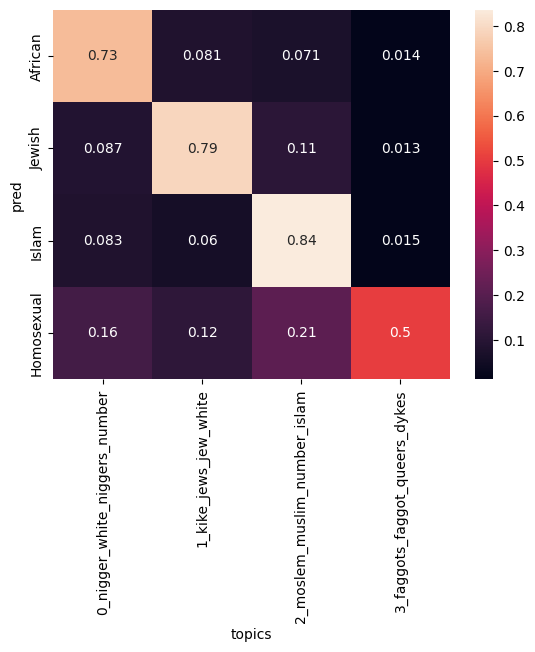

In [51]:
import seaborn as sns
sns.heatmap(n_p_g_hate_df, annot=True)

In [42]:
cf_matrix

,0_nigger_white_niggers_number,2_moslem_muslim_number_islam,3_faggots_faggot_queers_dykes,1_kike_jews_jew_white
African,0,0,0,0
Homosexual,0,0,0,0
Islam,0,0,0,0
Jewish,0,0,0,0
